## Downloading Data from Kaggle

In [ ]:
# !pip install --user kaggle
import pathlib
import os
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files("andrewmvd/animal-faces")

## Packages

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Load Images

In [5]:
image_path = []
labels = []

for i in os.listdir("afhq"):
    for label in os.listdir(f"afhq/{i}"):
        for image in os.listdir(f"afhq/{i}/{label}"):
            image_path.append(f"afhq/{i}/{label}/{image}")
            labels.append(label)
            
data = pd.DataFrame(zip(image_path, labels), columns=['image_path', 'labels'])

print(data.labels.unique())

data.head()

['cat' 'dog' 'wild']


,image_path,labels
0,afhq/train/cat/pixabay_cat_000455.jpg,cat
1,afhq/train/cat/pixabay_cat_001993.jpg,cat
2,afhq/train/cat/pixabay_cat_004633.jpg,cat
3,afhq/train/cat/pixabay_cat_002242.jpg,cat
4,afhq/train/cat/pixabay_cat_002524.jpg,cat


## Visualisation

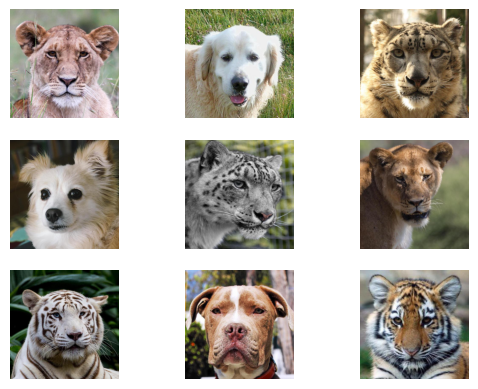

In [34]:
n_rows = n_cols = 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        
plt.show()

## Splitting Data

In [6]:
df = data.copy()

In [11]:
# Randomly sample 70% of the data to be training data
train_df = df.sample(frac=0.7)

# Drop training data based on index
test = df.drop(train_df.index)

# Use half of the test data as validation data
val_df = test.sample(frac=0.5)

# Drop validation data based on index  
test_df = test.drop(val_df.index)

# Explore shape of dataframes
print(
    train_df.shape,
    test_df.shape,
    val_df.shape,
    sep='\n'
)

(11291, 2)
(2419, 2)
(2420, 2)


## Data Preprocessing 

### Encoding Categorical Data

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

### Image Transformation

In [ ]:
# Ensure images have the same properties
transform_img = transforms.Compose(
    [
        # Change image size
        transforms.Resize([128, 128]),
        
        # Convert to tensor data
        transforms.ToTensor(),
        
        # Convert data to be a torch float type
        transforms.ConvertImageDtype(torch.float)
    ]
)

In [59]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device) # Transform encoded label into a tensor datatype
        
    # Number of rows in the datafram
    def __len__(self):
        return self.dataframe.shape[0]
        
    # Retrieve items at a specific index
    def __getitem__(self, index):
        # Retrieve image path
        img_path = self.dataframe.iloc[index, 0]
        
        # Retrieve label
        label = self.labels[index]
        
        # Retrieve image
        image = Image.open(img_path).convert('RGB')
        
        # Transform image
        if self.transform:
            image = self.transform(image).to(device)
            
        return image, label

In [60]:
train_images = CustomImageDataset(dataframe=train_df, transform=transform_img)
val_images = CustomImageDataset(dataframe=val_df, transform=transform_img)
test_images = CustomImageDataset(dataframe=test_df, transform=transform_img)

In [61]:
# Count number of training images
train_images.__len__()

# Retrieve image at index 2
train_images.__getitem__(2)

(tensor([[[0.3686, 0.4863, 0.5922,  ..., 0.2941, 0.3137, 0.3333],
          [0.3765, 0.3843, 0.4588,  ..., 0.2627, 0.2863, 0.3098],
          [0.4824, 0.5059, 0.5255,  ..., 0.2196, 0.2510, 0.2745],
          ...,
          [0.7098, 0.6941, 0.6784,  ..., 0.4118, 0.3922, 0.3176],
          [0.6902, 0.6824, 0.6824,  ..., 0.4588, 0.4353, 0.3647],
          [0.6863, 0.7020, 0.7020,  ..., 0.5216, 0.4902, 0.4353]],
 
         [[0.2980, 0.4078, 0.5137,  ..., 0.2941, 0.3137, 0.3333],
          [0.2980, 0.3020, 0.3686,  ..., 0.2627, 0.2863, 0.3098],
          [0.3922, 0.4118, 0.4235,  ..., 0.2196, 0.2510, 0.2745],
          ...,
          [0.6196, 0.6039, 0.5882,  ..., 0.3725, 0.3686, 0.3098],
          [0.6000, 0.5922, 0.5922,  ..., 0.4118, 0.4039, 0.3451],
          [0.5961, 0.6118, 0.6118,  ..., 0.4706, 0.4549, 0.4118]],
 
         [[0.2275, 0.3176, 0.3922,  ..., 0.3020, 0.3216, 0.3412],
          [0.2392, 0.2275, 0.2745,  ..., 0.2706, 0.2941, 0.3176],
          [0.3255, 0.3373, 0.3373,  ...,

In [ ]:
# Retrieve original label for encoded category
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

## Building PyTorch Model

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialising convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    
        # Pooling layer
        self.pooling = nn.MaxPool2d(2, 2)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Flatten image
        self.flatten = nn.Flatten()

        # Output goes through a layer of neurones
        self.linear = nn.Linear((128*16*16), 128)
        
        self.output = nn.Linear(128, len(df['labels'].unique()))
        
    def forward(self, x):
        
        # Increases the number of image features but does not change the image size
        x = self.conv1(x)       # (32, 128, 128)
        
        # Reduces the image size but does not change the number of features
        x = self.pooling(x)     # (32, 64, 64)
        
        # Does not change either the image size of image features
        x = self.relu(x)        
        
        x = self.conv2(x)       # (64, 64, 64)
        x = self.pooling(x)     # (64, 32, 32)
        x = self.relu(x)
        
        x = self.conv3(x)       # (128, 32, 32)
        x = self.pooling(x)     # (128, 16, 16)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        
        return x

In [63]:
model = Net().to(device)

In [64]:
# !pip3 install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

`-1` in the `Output Shape` is a placeholder for the batch size.

## Training & Validation

In [72]:
# Hyperparameters
lr=1e-4
n_batch=16
epochs=5

# Load image data
train_loader = DataLoader(train_images, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_images, batch_size=n_batch, shuffle=True)
test_loader = DataLoader(test_images, batch_size=n_batch, shuffle=True)

# Loss criterion
criterion = nn.CrossEntropyLoss()

# Optimise weights in the neural network
optimiser = Adam(model.parameters(), lr=lr)

In [74]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0
    
    for inputs, labels in train_loader:
        
        # Reset optimiser
        optimiser.zero_grad()
        
        # Pass inputs into the model
        outputs = model(inputs)
        
        # Calculate training loss (i.e., error)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        
        # Backpropagation
        train_loss.backward()
        
        # Calculate training accuracy (i.e., number of times the predicted and actual labels matched)
        train_acc = (torch.argmax(outputs, axis=1) == 1).sum().item()
        total_acc_train += train_acc
        
        # Improve model
        optimiser.step()
        
    
    # Validation process
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            
            # Calculate validation loss
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            # Calculate validation accuracy
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc
            
            
    total_loss_train = round(total_loss_train / 1000, 4)
    total_loss_val = round(total_loss_val / 1000, 4)
    
    total_acc_train = round(((total_acc_train / train_images.__len__()) * 100), 4)
    total_acc_val = round(((total_acc_val / val_images.__len__()) * 100), 4)
            
    total_loss_train_plot.append(total_loss_train)
    total_loss_val_plot.append(total_loss_val)
    total_acc_train_plot.append(total_acc_train)
    total_acc_val_plot.append(total_acc_val)
    
    print(
        f"Epoch {epoch + 1} out of {epochs}",
        f"Training loss : {total_loss_train}",
        f"Training accuracy : {total_acc_train}%",
        f"Validation loss : {total_loss_val}",
        f"Validation accuracy : {total_acc_val}%",
        "===================="
        sep='\n'
    )

Epoch 1 out of 5 Training loss : 0.1045 Training accuracy : 32.6012 Validation loss : 0.0194 Validation accuracy : 95.0826
Epoch 2 out of 5 Training loss : 0.0703 Training accuracy : 32.5215 Validation loss : 0.0205 Validation accuracy : 95.4132
Epoch 3 out of 5 Training loss : 0.0534 Training accuracy : 32.6543 Validation loss : 0.0156 Validation accuracy : 96.0744
Epoch 4 out of 5 Training loss : 0.0371 Training accuracy : 32.6012 Validation loss : 0.0177 Validation accuracy : 95.7025
Epoch 5 out of 5 Training loss : 0.0282 Training accuracy : 32.4595 Validation loss : 0.0223 Validation accuracy : 94.9587


## Testing

In [75]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()
        

total_acc_test = round(((total_acc_test / test_images.__len__()) * 100), 4)        
total_loss_test = round((total_acc_test / 1000) , 4)        

print(
    f"Test Accuracy: {total_acc_test}%",
    f"Test Loss: {total_loss_test}",
    sep='\n'
)

Test Accuracy: 95.0393%
Test Loss: 0.095


## Visualisation

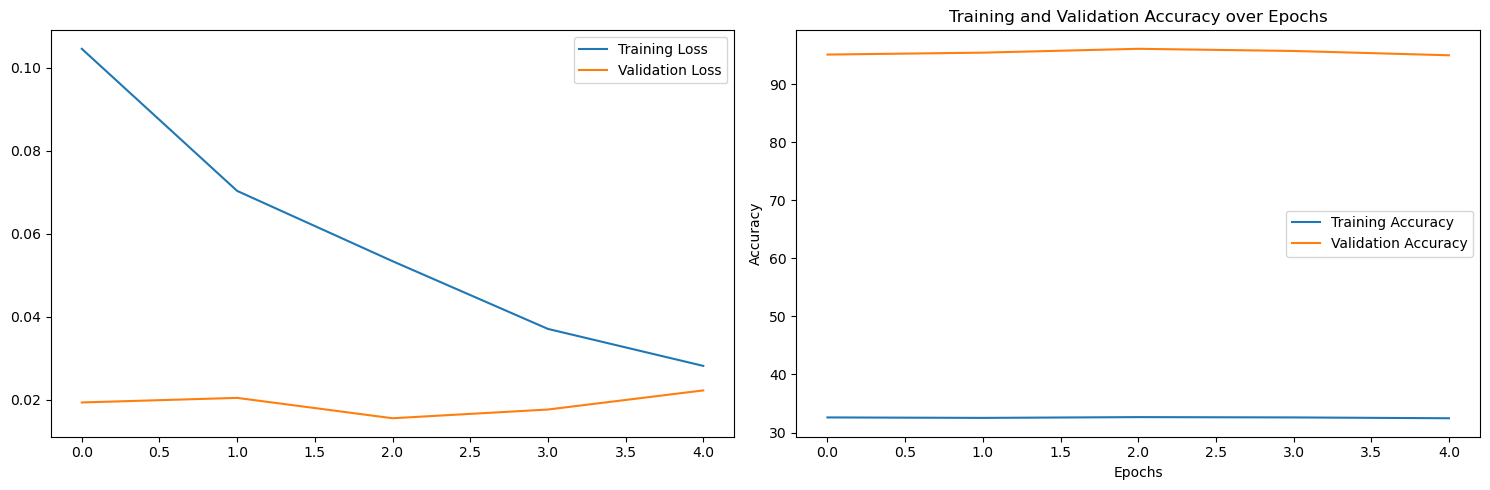

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(total_loss_train_plot, label='Training Loss')
axes[0].plot(total_loss_val_plot, label='Validation Loss')
axes[1].set(
    title="Training and Validation Loss over Epochs",
    xlabel="Epochs",
    ylabel="Accuracy",
)
axes[0].legend()

axes[1].plot(total_acc_train_plot, label='Training Accuracy')
axes[1].plot(total_acc_val_plot, label='Validation Accuracy')
axes[1].set(
    title="Training and Validation Accuracy over Epochs",
    xlabel="Epochs",
    ylabel="Accuracy",
)
axes[1].legend()

plt.tight_layout()
plt.show()

## Inference

1. Read image
2. Transform image
3. Predict using the model
4. Inverse transform the output using label encoder

In [77]:
def predict_image(image_path):
    
    # Read image
    image = Image.open(image_path).convert("RGB")
    
    # Transform image
    image = transform_img(image).to(device)
    
    # Predict using model 
    output = model(image.unsqueeze(0))  # Unsqueeze provides the batch number which is required by the model
    label_encoded = torch.argmax(output, axis=1).item()
    
    # Reverse transform the encoded data back to its label
    label = label_encoder.inverse_transform([label_encoded])
    
    return label

In [78]:
image_path = "prediction_image.jpg"

predict_image(image_path)

array(['cat'], dtype=object)

Source of image: https://upload.wikimedia.org/wikipedia/commons/7/75/Cute_grey_kitten.jpg

<p align="center">
  <img src="prediction_image.jpg" alt="cute-grey-kitten" width="300"/>
</p>